<a href="https://colab.research.google.com/github/rjcc/accent_detection/blob/master/AccentDetectionResNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Environment Setup

Lets import basic libraries required for most tasks

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime

%matplotlib inline 


Lets get the data from GitHub

In [0]:
!git clone https://github.com/rjcc/accent_detection.git

fatal: destination path 'accent_detection' already exists and is not an empty directory.


Lets install TF 2.0 Beta

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta0

Now we import the necessary modules to build the model.

Also do a sanity check on the version and confirm we are running with GPU's

In [0]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, Add, BatchNormalization, Input, ZeroPadding2D, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau 
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.initializers import RandomNormal, glorot_uniform
from tensorflow.keras.models import  load_model


print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0-beta0
True


Now, lets setup some useful variables used for the training

In [0]:
# Notebook version token to associated with generated output
NBV = "ResNet_V1"

# Binary classification we only use one class
NUM_CLASSES = 3

# Since we are working with colored images, we need to specify 3 channels
CHANNELS = 1

BATCH_SIZE = 32

# Activation for last Dense layer in Binary classfication
DENSE_LAYER_ACTIVATION = 'softmax'

# Objective function used for binary classification
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['categorical_accuracy'] #sparse_categorical_accuracy

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 200
EARLY_STOP_PATIENCE = 20

TRAINING_PATH = "/content/accent_detection/train/" 
TEST_PATH = "/content/accent_detection/test/predict"

LABELS = "/content/accent_detection/train_labels.csv"

#TENSORBOARD_LOGS = "/content/gdrive/My Drive/MalariaDetectionProject/Tensorboard/"

PROJECT_FOLDER= "/content/accent_detection/"
OUTPUT_FOLDER = "/content/drive/My Drive/Accent_Detection_Out/"

#image sizes taken from problem description
img_width = 173
img_height = 128

RETRAIN = False

# Preparing the data sets

Define the input shape to feed into our model

In [0]:
if  tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (CHANNELS, img_width, img_height)
else:
    input_shape = (img_width, img_height, CHANNELS)
    

print(tf.keras.backend.image_data_format())
print(input_shape)

channels_last
(173, 128, 1)


Lets read the CSV with the file names and respective labels.

Infected is modified as one of the functions used below required it to be a string. (flow_from_dataframe()  ?)

Filename is also adusted so that the file scan be fectched from the folder.

In [0]:
labels = pd.read_csv(LABELS)
labels.head()

,file_id,accent
0,10000,1
1,10001,1
2,10002,0
3,10003,2
4,10004,1


In [0]:
def replace_label(label):
    txt = ""
    if label == 0 :
        txt ="Canada"
    elif label == 1:
        txt = "India"
    elif label == 2:
        txt = "England"
    
    return txt
    

#labels["accent"] = labels["accent"].map(lambda x: replace_label(x))
labels["accent"] = labels["accent"].astype(str)
labels["file_id"] = labels["file_id"].map(lambda x: "./{}.png".format(x))

labels.head() #sanity check

,file_id,accent
0,./10000.png,1
1,./10001.png,1
2,./10002.png,0
3,./10003.png,2
4,./10004.png,1


Now lets split the 

In [0]:
from sklearn.model_selection import train_test_split 
train, val = train_test_split(labels, random_state = 123, test_size=0.25, stratify=labels['accent'])

#sanity check
train.head() 


,file_id,accent
1187,./11187.png,2
2937,./12937.png,0
3861,./13861.png,1
3123,./13123.png,1
2971,./12971.png,2


In [0]:
val.head()

,file_id,accent
2488,./12488.png,1
1570,./11570.png,0
1411,./11411.png,0
3069,./13069.png,1
4376,./14376.png,0


Lets sort the dataframes so that the ImageGenerator can correctly map the classes.

In [0]:
train.sort_values(by=["accent"],inplace=True)
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,file_id,accent
1430,./11430.png,0
2511,./12511.png,0
3047,./13047.png,0
3002,./13002.png,0
4151,./14151.png,0


In [0]:
val.sort_values(by=["accent"],inplace=True)
val.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,file_id,accent
3242,./13242.png,0
1782,./11782.png,0
1789,./11789.png,0
339,./10339.png,0
789,./10789.png,0


Let's save the two generated dataframes for posterior analysis

In [0]:
train_split_file= "train_split.csv".format(OUTPUT_FOLDER,NBV)
val_split_file= "validation_split.csv".format(OUTPUT_FOLDER,NBV)

print(f"Saving train split file to {train_split_file}")
train.to_csv(train_split_file,header = True,index = False)

print(f"Saving validation split file to {val_split_file}")
val.to_csv(val_split_file,header=True, index = False)


Saving train split file to /content/drive/My Drive/Accent_Detection_Out/train_split_ResNet_V1.csv
Saving validation split file to /content/drive/My Drive/Accent_Detection_Out/validation_split_ResNet_V1.csv


As a sanity check, lets observe the distrobution of the labels after the split

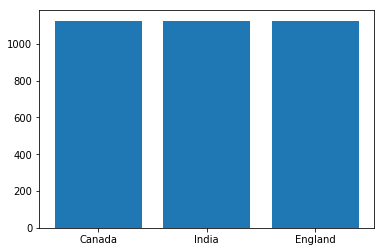

Train Canada count:1125; Percentage from original:0.75
Train India count:1125; Percentage from original:0.75
Train India count:1125; Percentage from original:0.75


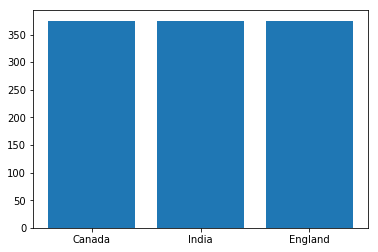

Validation infected count:375; Percentage from original:0.25
Validation infected count:375; Percentage from original:0.25
Validation infected count:375; Percentage from original:0.25


In [0]:
filter_canada = labels['accent'] == "0"
filter_india = labels['accent'] == "1"
filter_england = labels['accent'] == "2"

count_canada = labels.where(filter_canada).count()['accent']
count_india = labels.where(filter_india).count()['accent']
count_england = labels.where(filter_england).count()['accent']

train_count_canada = train.where(train['accent'] == "0").count()['accent']
train_count_india = train.where(train['accent'] == "1").count()['accent']
train_count_england = train.where(train['accent'] == "2").count()['accent']

cat = ["Canada", "India", "England"]
count = [train_count_canada,train_count_india, train_count_england]
plt.bar(cat,count)
plt.show()

print(f"Train Canada count:{train_count_canada}; Percentage from original:{ train_count_canada/count_canada }")
print(f"Train India count:{train_count_india}; Percentage from original:{ train_count_india/count_india }")
print(f"Train India count:{train_count_england}; Percentage from original:{ train_count_england/count_england }")

val_count_canada = val.where(val['accent'] == "0").count()['accent']
val_count_india = val.where(val['accent'] == "1").count()['accent']
val_count_england = val.where(val['accent'] == "2").count()['accent']



count = [val_count_canada,val_count_india,val_count_england]
plt.bar(cat,count)
plt.show()

print(f"Validation infected count:{val_count_canada}; Percentage from original:{ val_count_canada/count_canada }")
print(f"Validation infected count:{val_count_india}; Percentage from original:{ val_count_india/count_india }")
print(f"Validation infected count:{val_count_england}; Percentage from original:{ val_count_england/count_england }")

Finally, lets prepare the images to be streamed during training.

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #rotation_range= 360,
        #shear_range=0.1,
        #zoom_range=0.1,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range =[0.8,1.2])

validation_datagen= ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(train, 
                                                    directory=TRAINING_PATH, 
                                                    x_col='file_id', 
                                                    y_col='accent', 
                                                    target_size=(img_height, img_width), 
                                                    color_mode='grayscale', 
                                                    classes=["0","1","2"], 
                                                    class_mode='categorical', 
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle=True,  
                                                    save_to_dir=None)
    
validation_generator = validation_datagen.flow_from_dataframe(val, 
                                                    directory=TRAINING_PATH, 
                                                    x_col='file_id', 
                                                    y_col='accent', 
                                                    target_size=(img_height, img_width), 
                                                    color_mode='grayscale', 
                                                    classes=["0","1","2"], 
                                                    class_mode='categorical', 
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle=True,  
                                                    save_to_dir=None)

Found 3375 validated image filenames belonging to 3 classes.
Found 1125 validated image filenames belonging to 3 classes.


In [0]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'0': 0, '1': 1, '2': 2}
{'0': 0, '1': 1, '2': 2}


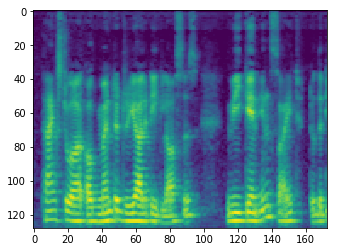

In [0]:
from skimage import io
import matplotlib.pyplot as plt

my_image = io.imread('/content/accent_detection/train/10000.png', as_gray=True)

# look at the image
plt.imshow(my_image)

# Build the model

In [0]:
if RETRAIN:
    model= load_model(f"{OUTPUT_FOLDER}CustomNet_{NBV}_best.hdf5")

else:    
    base_model = ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,CHANNELS))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.70)(x)
    predictions = Dense(NUM_CLASSES, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)


model.compile(optimizer = 'adam', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0702 22:20:14.120826 139800166623104 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 173, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 179, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 87, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 87, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

# Train the model

In [0]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

if RETRAIN:
    cb_checkpointer = ModelCheckpoint(filepath = f"{OUTPUT_FOLDER}CustomNet_{NBV}_retrained_best.hdf5", monitor = 'val_categorical_accuracy', save_best_only = True, mode = 'max', verbose= 1)
   
else:
    cb_checkpointer = ModelCheckpoint(filepath = f"{OUTPUT_FOLDER}CustomNet_{NBV}_best.hdf5", monitor = 'val_categorical_accuracy', save_best_only = True, mode = 'max', verbose= 1)


#logdir=TENSORBOARD_LOGS + "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq= 'batch', histogram_freq=1)
#print(f"Tensorboard folder:{logdir}")

STEPS_PER_EPOCH_TRAINING = train_generator.n // train_generator.batch_size
STEPS_PER_EPOCH_VALIDATION = validation_generator.n // validation_generator.batch_size

print(f"STEPS_PER_EPOCH_TRAINING:{STEPS_PER_EPOCH_TRAINING}; STEPS_PER_EPOCH_VALIDATION: {STEPS_PER_EPOCH_VALIDATION}")


fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION, #callbacks=[cb_checkpointer, cb_early_stopper,tensorboard_callback,reduce_lr
        callbacks=[cb_checkpointer])

if RETRAIN:
    model.load_weights(f"{OUTPUT_FOLDER}CustomNet_{NBV}_retrained_best.hdf5")

else:
    model.load_weights(f"{OUTPUT_FOLDER}CustomNet_{NBV}_best.hdf5")

STEPS_PER_EPOCH_TRAINING:105; STEPS_PER_EPOCH_VALIDATION: 35
Epoch 1/200


W0702 22:20:14.903398 139800166623104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


104/105 [============================>.] - ETA: 0s - loss: 1.8569 - categorical_accuracy: 0.3748
Epoch 00001: val_categorical_accuracy improved from -inf to 0.37411, saving model to /content/drive/My Drive/Accent_Detection_Out/CustomNet_ResNet_V1_best.hdf5
105/105 [==============================] - 80s 761ms/step - loss: 1.8505 - categorical_accuracy: 0.3763 - val_loss: 6.1566 - val_categorical_accuracy: 0.3741
Epoch 2/200
104/105 [============================>.] - ETA: 0s - loss: 1.6282 - categorical_accuracy: 0.3685
Epoch 00002: val_categorical_accuracy did not improve from 0.37411
105/105 [==============================] - 27s 255ms/step - loss: 1.6295 - categorical_accuracy: 0.3682 - val_loss: 10.7214 - val_categorical_accuracy: 0.3348
Epoch 3/200
104/105 [============================>.] - ETA: 0s - loss: 1.4639 - categorical_accuracy: 0.4017
Epoch 00003: val_categorical_accuracy did not improve from 0.37411
105/105 [==============================] - 27s 254ms/step - loss: 1.4679 -

# Evaluate the training

Let's plot the traininng progress

In [0]:
# summarize history for accuracy
plt.plot(fit_history.history['sparse_categorical_accuracy'])
plt.plot(fit_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Lets also try to use Tensorboard.

# Review the model accuracy

To do this we will use scikit learn to review some of the binary classification metrics.

We will do a prediction over the validation data set and we will then compare the ground thruth with the predicted probabilities.

In [0]:
# TODO: read the validation split file
df = pd.read_csv(val_split_file)
df.head()


In [0]:
# TODO: perform necessary adjustments to the dataframe
#df["infected"] = df["infected"].map(lambda x: "1" if x == "infected" else "0")
df["file_id"] = df["file_id"].map(lambda x: x[2:] )
df.head()

In [0]:

# TODO: Add a column to store the prediction value
def predict_val_prob(filename):
    
    file_path = os.path.join(TRAINING_PATH,filename)
    img = load_img(file_path, color_mode='grayscale', target_size=(img_height,img_width) )
    img_array = img_to_array(img)

    img_array = img_array * (1./255) #scaling the data
    dim_array= np.array([img_array]) #tranforming to 4D array required as input
    
    prediction = model.predict(dim_array, verbose = 0)
    
    return np.argmax(prediction[0])

# TODO: Iterate over each file in df and perform the prediction using the model. update the prediction column wiht the value

df["predicted"] = df["file_id"].map(lambda x: predict_val_prob(x) )



In [0]:
correct_results= df[df.accent == df.predicted]
count_accurate = correct_results.count()["file_id"]
total_count = df.count()["file_id"]
print(f"correct results percentage: {count_accurate/total_count}")
correct_results.head()
# TODO: Add a column to transform the probabilty into the actual class ( 1= infected, 0= not infected)
# TODO: Use sklearn functions for auc, confusion matrix, precision and recall, etc



In [0]:
#from sklearn.metrics import log_loss

#log_loss(df["infected"],df["predicted"])

# TODO: Use the same log loss formula as in the case description to calculate the log loss of the predicted values

In [0]:
#simple model test
file_path ="/content/accent_detection/train/13242.png"


from skimage import io



#img = io.imread(file_path, as_gray=True)
#print(f"Processing file {file_path} ...")
img = load_img(file_path, color_mode='grayscale', target_size=(img_height,img_width) )
img_array = img_to_array(img)
print(img_array.shape)
img_array = img_array * (1./255) #scaling the data
dim_array= np.array([img_array]) #tranforming to 4D array required as input

prediction = model.predict(dim_array, verbose = 0)

print(prediction)
print(np.argmax(prediction[0]))

# Save answers for submission

In [0]:
if RETRAIN:
    model= load_model(f"{OUTPUT_FOLDER}CustomNet_{NBV}_retrained_best.hdf5")

else:
    model= load_model(f"{OUTPUT_FOLDER}CustomNet_{NBV}_best.hdf5")



In [0]:

test_dir= TEST_PATH


with open(f"/content/accent_detection/submission_format.csv", mode='r') as submission_format:
    csv_reader = csv.reader(submission_format, delimiter=',')

    with open(f"{OUTPUT_FOLDER}answers_{NBV}_.csv", 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_NONE)
        
        csv_writer.writerow(["file_id","accent"]) # write header of answer file

        for row in csv_reader:
            if row[0] != "file_id": #skip reading the header row
                file_path =os.path.join(test_dir,f"{row[0]}.png")

                #print(f"Processing file {file_path} ...")
                img = load_img(file_path, color_mode='grayscale', target_size=(img_height,img_width) )
                img_array = img_to_array(img)

                img_array = img_array * (1./255) #scaling the data
                dim_array= np.array([img_array]) #tranforming to 4D array required as input
                
                prediction = model.predict(dim_array, verbose = 0)

                #print("Prediction for file {0} = {1}".format(row[0],prediction[0]))
                csv_writer.writerow([row[0], "{0}".format(np.argmax(prediction[0]))])


print("Done!")

# Inspirational references

https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

https://software.intel.com/en-us/articles/hands-on-ai-part-14-image-data-preprocessing-and-augmentation

Resnet: https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

### Troubleshooting
https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

https://www.analyticsvidhya.com/blog/2016/10/tutorial-optimizing-neural-networks-using-keras-with-image-recognition-case-study/